## Import Necessary Libraries

In [1]:
import time

import numpy as np
import pandas as pd
import datetime as dt
import xgboost as xgb
import seaborn as sns

from matplotlib import ticker
import matplotlib.pyplot as plt

from winsound import Beep as Bp
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

In [2]:
def pls():
    """ Audio alert function. Windows machines only. Remove prior to submission. """
    for i in range(1,10):
        freq = 150 if i%2 == 0 else 250
        Bp(freq,200)

## Load the Data

In [3]:
blob_path = 'https://gen10datafund2202.blob.core.windows.net/jedscontainer/911_Calls_For_Service.csv'
source_path = 'https://opendata.arcgis.com/api/v3/datasets/4f49eb825f564efa9a23cd103c4ba13b_0/downloads/data?format=csv&spatialRefId=4326'

start = time.perf_counter()
detroit_911 = pd.read_csv(blob_path, thousands = ",")#, nrows = 100000)
print(time.perf_counter() - start)
pls()

143.27644859999998


## Clean the Data

In [4]:
# Make a copy of the dataframe so that I don't have to redownload it every time I want to refresh.
detroit_df = detroit_911.copy()

# Count all the null values in the columns
null_values = detroit_df.isnull().sum().reset_index().rename(columns = {'index':'feature', 0: "null_values"})
null_values.sort_values(by = 'null_values', ascending = False, inplace = True)
null_values['null_ratio'] = (null_values['null_values'] / detroit_df.shape[0]) * 100
null_values['total'] = 100

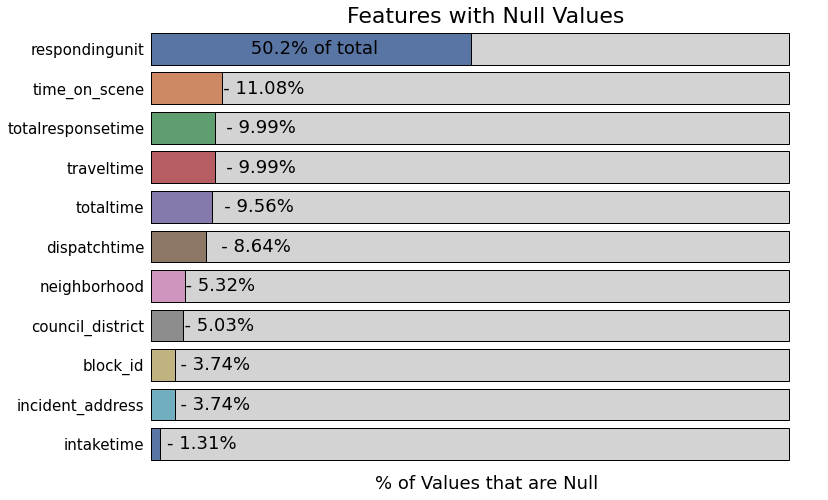

In [5]:
plt.rcParams['ytick.labelsize'] = 15

fig = plt.figure(figsize = (12,8))
plt.title('Features with Null Values', fontsize = 22)

null_ax = sns.barplot(data = null_values[(null_values['null_ratio'] > 0)], x='total', y='feature', color = 'lightgrey', edgecolor = 'black')
null_ax1 = sns.barplot(data = null_values[(null_values['null_ratio'] > 0)], x='null_ratio', y='feature', palette = 'deep', edgecolor = 'black')

null_ax.set_ylabel("")
null_ax.set_xlabel('% of Values that are Null', fontsize = 18)

null_ax.tick_params(bottom = False, left = False)
for c in null_ax.containers:
    labels = []
    for v in c:
        if (h := v.get_width()) == 100:
            lab = ""
        elif (h := v.get_width()) > 14:
            lab = f' {(h/100)*100:0.1f}% of total'
        elif (h := v.get_width()) > 7:
            lab = f'  {" "*25}- {(h/100)*100:0.2f}%'
        elif (h := v.get_width()) > 3:
            lab = f'  {" "*16}- {(h/100)*100:0.2f}%'
        else:
            lab = f'{" "*16}- {(h/100)*100:0.2f}%'
        labels.append(lab)

    null_ax.bar_label(c,labels=labels,label_type = 'center',fontsize = 18,color= 'black')#, weight = 'bold')
    
null_ax.set(xticklabels = [])
sns.despine(bottom = True, left = True)

In [6]:
detroit_df.head(5).T

,0,1,2,3,4
X,-82.986962,-83.185213,-83.146057,-83.191603,-83.175124
Y,42.408358,42.430914,42.43877,42.358257,42.360867
incident_id,201626400002,201626400019,201626400020,201626400024,201626400029
agency,DPD,DPD,DPD,DPD,DPD
incident_address,Promenade Ave & Roseberry St,Ardmore St & W 7 Mile Rd,Pembroke Ave & Prairie St,Joy Rd & Robson St,Littlefield St & Ellis St
zip_code,48213,48235,48221,48228,48228
priority,3,2,3,3,3
callcode,825030,811020,374030,825030,374030
calldescription,DISTURBANCE,AUTO X UNK INJ / IMPAIRED,RECOVER AUTO,DISTURBANCE,RECOVER AUTO
category,DISTURB,ACCUNK,RECAUTO,DISTURB,RECAUTO


### Drop Unused Features
> We dropped features that... Explain this further

In [7]:
# Drop columns that will not be used in algorithm
detroit_df.drop(
    columns = [
        'incident_id',
        'zip_code',
        'oid',
        'respondingunit',
        'agency',
        'X',
        'Y',
        'longitude',
        'latitude',
        'incident_address',
        'block_id',
        'category'
    ], inplace = True)

### Fix Missing Priorities
> Explain what we are doing here. (Remember that some of the priorities were missing so we matched the call description up with a matching call description)

In [8]:
mapped_priorities = detroit_df.groupby(by = ['priority'])['calldescription'].apply(lambda x: ', '.join(x)).reset_index()
mapped_priorities['calldescription'] = mapped_priorities['calldescription'].apply(lambda x: ", ".join(_.strip() for _ in set(x.split(","))))

priority_dict = {}
for priority in mapped_priorities['priority'].unique():
    priority_dict[priority] = mapped_priorities[(mapped_priorities.priority == priority)]['calldescription'].values.tolist()[0]

del priority_dict[" "]

def get_priority(current_priority, call_descrip):
    if current_priority != " ":
        return current_priority
    for key in priority_dict.keys():
        if call_descrip in priority_dict[key]:
            return key   
    return 'FAIL'

detroit_df['new_priority'] = detroit_df.apply(lambda row: get_priority(row.priority, row.calldescription), axis = 1)

detroit_df.drop(columns = ['priority'], inplace = True)
detroit_df.rename(columns = {'new_priority': 'priority'}, inplace = True)


### Drop two of the time columns
> Explain why we did this.

In [9]:
detroit_df.drop(columns = ['totaltime','totalresponsetime'], inplace = True)


### Convert timestamp to weekday

In [10]:
def return_weekday(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00').date()
    return dt.datetime.strftime(time, '%A')
    
detroit_df['weekday'] = detroit_df['call_timestamp'].apply(lambda x: return_weekday(x))

### Convert Timestamp to Part of Day

In [11]:
def get_daypart(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00')
    time = dt.datetime.strftime(time, '%H:%M:%S')
    if time < "06:00":
        time_of_day = "Early Morning"
    elif time >= "06:00" and time < "10:00":
        time_of_day = "Morning"
    elif time >= "10:00" and time < "12:00":
        time_of_day = "Late Morning"
    elif time >= "12:00" and time < "15:00":
        time_of_day = "Afternoon"
    elif time >= "15:00" and time < "18:00":
        time_of_day = "Late Afternoon"
    elif time >= "18:00" and time < "21:00":
        time_of_day = "Early Evening"
    elif time >= "21:00":
        time_of_day = "Evening"
    else:
        time_of_day = "FAILED"
    return time_of_day

detroit_df['day_part'] = detroit_df['call_timestamp'].apply(lambda x: get_daypart(x))


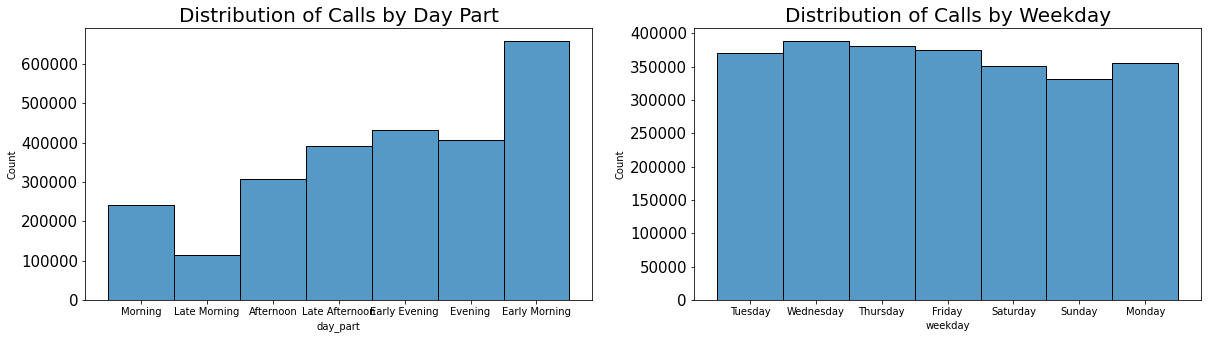

In [23]:
fig, axs = plt.subplots(1,2, figsize = (20,5))
axs[0].set_title("Distribution of Calls by Day Part", fontsize = 20)
axs[1].set_title("Distribution of Calls by Weekday", fontsize = 20)
sns.histplot(data = detroit_df, x = 'day_part', ax = axs[0])
sns.histplot(data = detroit_df, x = 'weekday', ax = axs[1])
plt.show()

In [24]:
detroit_df.head()

,callcode,calldescription,call_timestamp,precinct_sca,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,825030,DISTURBANCE,2016/09/20 09:36:12+00,910A,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,811020,AUTO X UNK INJ / IMPAIRED,2016/09/20 09:46:32+00,1201,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,374030,RECOVER AUTO,2016/09/20 09:48:24+00,123B,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,825030,DISTURBANCE,2016/09/20 09:50:29+00,0207,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,374030,RECOVER AUTO,2016/09/20 09:54:37+00,28A,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning


### Drop columns that will not be used for prediction.

In [25]:
detroit_df.drop(columns = ['callcode','call_timestamp','precinct_sca'], inplace = True)

In [26]:
# We initially wanted to use call description, but it reduced the accuracy of the prediction
detroit_df.drop(columns = ['calldescription'], inplace = True) 

### Create a save point so that data reloading is unneccessary.

In [28]:
backup_detroit = detroit_df.copy()

# Checkpoint
### To avoid overwriting detroit_df during a reload, run from this point

In [44]:
backup_detroit.head(1)

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning


In [45]:
detroit_df = backup_detroit.copy()

In [46]:
detroit_df_subset = detroit_df.head(5000)

<AxesSubplot:title={'center':'Distribution of a subset of the data'}, xlabel='time_on_scene', ylabel='Count'>

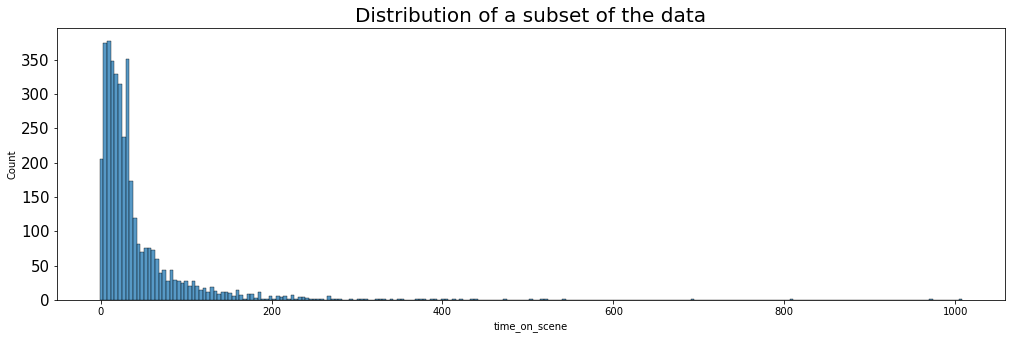

In [47]:
fig = plt.figure(figsize = (17,5))
plt.title('Distribution of a subset of the data', fontsize = 20)
sns.histplot(data = detroit_df_subset, x='time_on_scene')

### Establish what we are trying to predict.
> We want to know, given certain characteristics, what is the likelihood that an officers<br>
time on scene will be more than the average (around 32.7 minutes).

In [48]:
data_mean = detroit_df['time_on_scene'].mean()
detroit_df['on_scene_time_gt_mean'] = detroit_df['time_on_scene'].apply(lambda x: 1 if x > data_mean else 0)

### Drop the column that was used to generate our prediction column because it will correlate too highly.

In [49]:
detroit_df.drop(columns = ['time_on_scene'], inplace = True)

### Establish X - The independent features

In [51]:
X = detroit_df.drop(columns = ['on_scene_time_gt_mean']).copy()

### Establish Y - The dependent feature

In [53]:
y = detroit_df['on_scene_time_gt_mean'].copy()

In [54]:
X.select_dtypes('object')

,officerinitiated,neighborhood,priority,weekday,day_part
0,No,Wade,3,Tuesday,Morning
1,No,Tri-Point,2,Tuesday,Morning
2,No,Oak Grove,3,Tuesday,Morning
3,No,We Care Community,3,Tuesday,Morning
4,No,Barton-McFarland,3,Tuesday,Morning
...,...,...,...,...,...
2551995,No,Oakman Blvd Community,3,Monday,Late Morning
2551996,No,North Corktown,2,Monday,Late Morning
2551997,No,Oakman Blvd Community,3,Monday,Late Morning
2551998,No,Warrendale,1,Monday,Late Morning


In [55]:
X_encoded = pd.get_dummies(X)
# detroit_dummied.shape

# It is better to use One-Hot-Encoding than get_dummies because OHE saves the exploded categories into its object, but we are using get_dummies for ease



In [56]:
X_encoded.head()

,intaketime,dispatchtime,traveltime,council_district,officerinitiated_No,officerinitiated_Yes,neighborhood_Airport Sub,neighborhood_Arden Park,neighborhood_Aviation Sub,neighborhood_Bagley,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,day_part_Afternoon,day_part_Early Evening,day_part_Early Morning,day_part_Evening,day_part_Late Afternoon,day_part_Late Morning,day_part_Morning
0,2.2,528.6,15.5,4.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2.7,5.2,6.4,2.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,4.9,NaN,NaN,2.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.4,3.4,7.6,7.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,3.0,1645.3,NaN,7.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [57]:
X_encoded.fillna(0, inplace = True)

### Preserve the time needed to run various combinations.

In [59]:
running_time = []

### Primary Algorithms

In [65]:
def tune_classifier(X,y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42, stratify = y
    )
    
    optimal_params = GridSearchCV(
        estimator=xgb.XGBClassifier(
            objective='binary:logistic',
            seed = 42,
            subsample=0.9,
            colsample_bytree=0.5
        ),
        param_grid=param_grid1,
        scoring='roc_auc',
        verbose=2,
        n_jobs=10,
        cv=3
    )
    
    optimal_params.fit(X_train, 
                y_train, 
                verbose = False,
                early_stopping_rounds=10, 
                eval_metric='auc',
                eval_set=[(X_test, y_test)]
               )
    
    print(optimal_params.best_params_)
    return(optimal_params.best_params_)
    #possible save hyper results
    
def run_classifier(X,y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42, stratify = y
    )
    
    xgb_reg = xgb.XGBClassifier(objective='binary:logistic',
                               seed = 42,
                               subsample=0.9,
                               colsample_bytree=0.5)
    
    xgb_reg.fit(X_train,
                y_train,
                verbose = 2,
                early_stopping_round=10,
                eval_metric='auc',
                eval_set=[(X_test, y_test)]
               )
    
    
hyper_scores = {
    'max_depth': [],
    'learning_rate': [],
    'gamma': [], 
    'reg_lambda': [],
    'scale_pos_weight': [],
    'accuracy': []
}

param_grid1 = {
    'max_depth': [3,4,5,6,7,8],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0, 2.0], 
    'reg_lambda': [10.0, 20, 100],
    'scale_pos_weight': [1,2,3,4,5],
}

param_grid2 = {
    'max_depth': [4],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0.25], 
    'reg_lambda': [10.0, 20, 100],
    'scale_pos_weight': [3],
}

size = 3000
X_subset = X_encoded.head(size)
y_subset = y.head(size)

start_time = time.perf_counter()
optimal_metrics = tune_classifier(X_subset,y_subset)
running_time.append([size, time.perf_counter() - start_time, optimal_metrics])
print(running_time)
pls()

# Best at 100_000 {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}

# num_rows	runtime	runtime_mins
# 0	20000	355.851673	5.930861
# 1	50000	1072.080725	17.868012
# 2	100000	2874.519241	47.908654

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


C:\Users\Work\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}
[[100, 7.506206399999883, {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 20, 'scale_pos_weight': 3}], [500, 10.50444540000035, {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 20, 'scale_pos_weight': 3}], [1000, 13.218416400000024, {'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}], [1000, 16.56570929999998, {'gamma': 2.0, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 20, 'scale_pos_weight': 3}], [2000, 47.599254499999915, {'gamma': 2.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 100, 'scale_pos_weight': 3}], [3000, 464.6169553, {'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}]]


In [ ]:
#elapsed_df = pd.read_csv('data_')

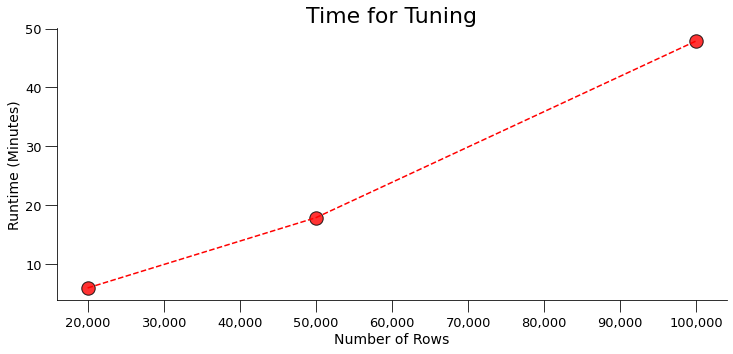

In [87]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig = plt.figure(figsize = (12,5))
plt.title("Time for Tuning", fontsize = 22)
ax = sns.scatterplot(data = elapsed_df, x = 'num_rows', y='runtime_mins', s = 180, alpha = 0.8, edgecolor = 'black', color = 'red')
ax = sns.lineplot(data = elapsed_df, x = 'num_rows', y='runtime_mins', linestyle = 'dashed', color= 'red')

ax.set_xlabel('Number of Rows', fontsize = 14)
ax.set_ylabel('Runtime (Minutes)', fontsize = 14)
ax.ticklabel_format(style = 'plain')
ax.tick_params(size = 12)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
sns.despine()

In [40]:
score_frame = pd.DataFrame(scores, columns = ['size','accuracy'])

In [41]:
score_frame

,size,accuracy
0,100000,0.70360
1,500000,0.73886


In [ ]:
assert 1 == 2

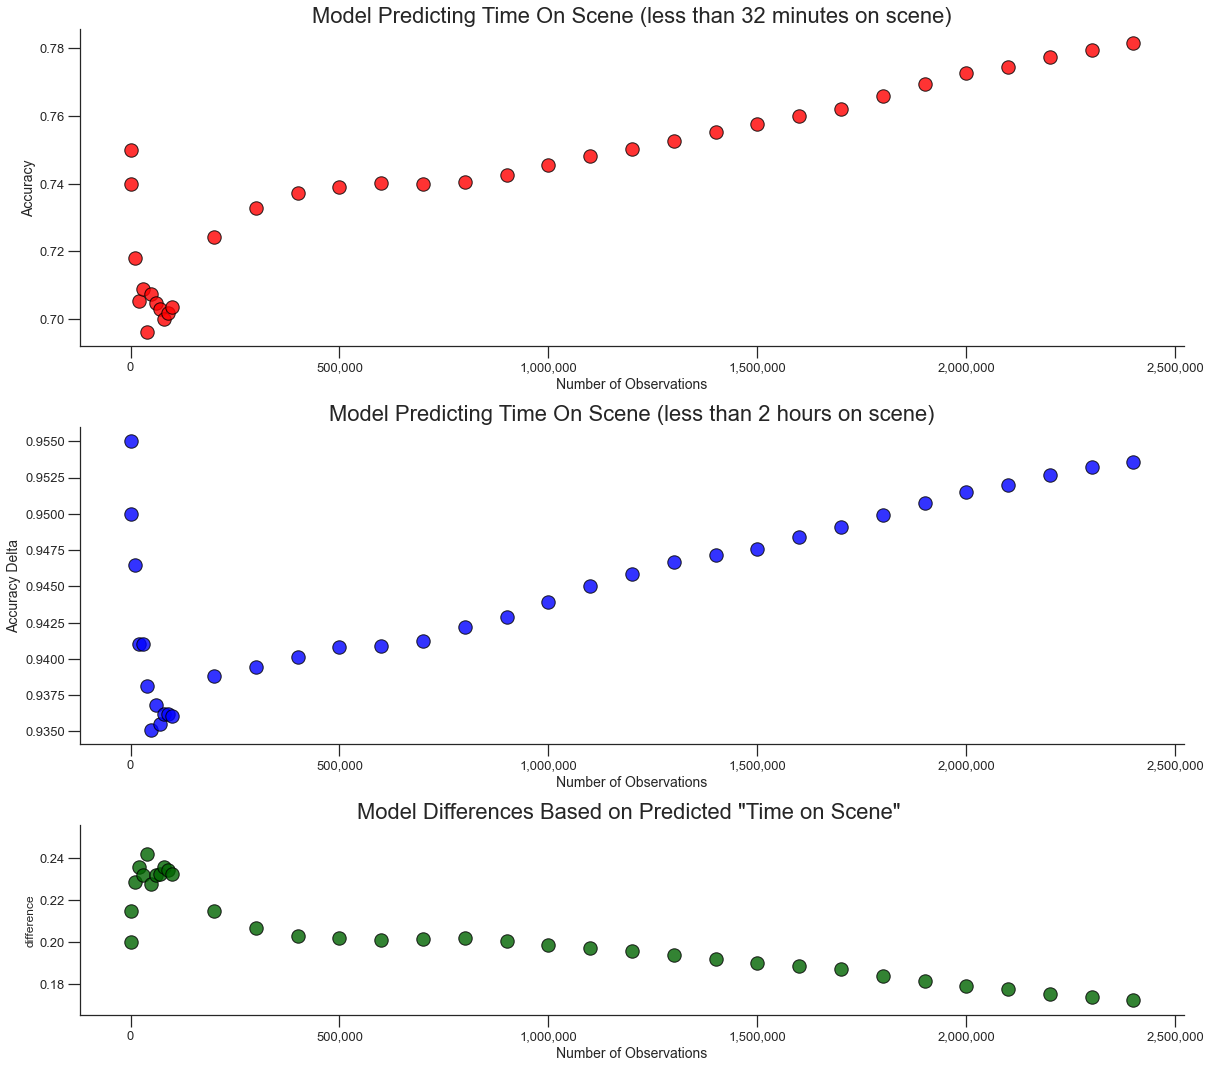

In [254]:
score_frame = prediction_scores
sns.set_style('ticks')

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig, axs = plt.subplots(3, 1, figsize = (17,15), gridspec_kw={'height_ratios':[.5,.5,.3]}, sharex = False)
#plt.title("Accuracy vs. Number of Observations", fontsize = 22)

axs[0].set_title('Model Predicting Time On Scene (less than 32 minutes on scene)', fontsize = 22)
axs[1].set_title('Model Predicting Time On Scene (less than 2 hours on scene)', fontsize = 22)
axs[2].set_title('Model Differences Based on Predicted "Time on Scene" ', fontsize = 22)

sns.scatterplot(data = score_frame, x = 'num_observations', y = '32.7 minutes', s = 180, alpha = .8, edgecolor = 'black', color = 'red', ax = axs[0])
sns.scatterplot(data = score_frame, x = 'num_observations', y= '120 minutes', s= 180, alpha = .8, edgecolor = 'black', color = 'blue', ax = axs[1])
sns.scatterplot(data = score_frame, x = 'num_observations', y= 'difference', s= 180, alpha = .8, edgecolor = 'black', color = 'darkgreen', ax = axs[2])

# axs[0].axhline(score_frame['accuracy'].max(), color = 'black', linestyle = 'dashed')
# plt.axhline(score_frame['accuracy'].min(), color = 'black', linestyle = 'dashed')
# plt.axhline(score_frame['accuracy'].mean(), color = 'black', linestyle = 'dashed')
axs[0].set_ylabel('Accuracy', fontsize = 14)
axs[1].set_ylabel('Accuracy Delta', fontsize = 14)
axs[2].set_ylim([0.165,.256])
# ax.set_xlim([-1000,2500000])
#ax[1].set_ylim([.95,.955])
for ax in axs:
    ax.ticklabel_format(style = 'plain')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.tick_params(size = 12)
    ax.set_xlabel("Number of Observations", fontsize = 14)
    
# most_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].max())]["size"].values[0]
# least_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].min())]["size"].values[0]
# ax.annotate(f'Max Accuracy: {(score_frame["accuracy"].max()) * 100}% at {"{:,}".format(most_accurate)} observations', 
#             xy= [100000,.95556], 
#             fontsize = 16)
# ax.annotate(f'Min Accuracy: {(score_frame["accuracy"].min()) * 100}% at {"{:,}".format(least_accurate)} observations', 
#             xy= [150000,.934], 
#             fontsize = 16)
#sns.set(rc = {'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.despine()
plt.tight_layout()
plt.savefig("XGB_classifier_vs-3")

In [242]:

prediction_scores.rename(columns = {'accuracy': '120 minutes', '32 minute': '32.7 minutes', 'size': 'num_observations'}, inplace = True)

In [ ]:
prediction_scores['difference'] = prediction_scores['120 minutes'] - prediction_scores["32.7 minutes"]
prediction_scores

In [247]:
prediction_scores.to_csv('prediction_scores_xgb_baseline.csv', index = False)

In [38]:
other_data = pd.read_csv('xgb_classifier_attempt_1.csv')
other_data = other_data.tail(5)

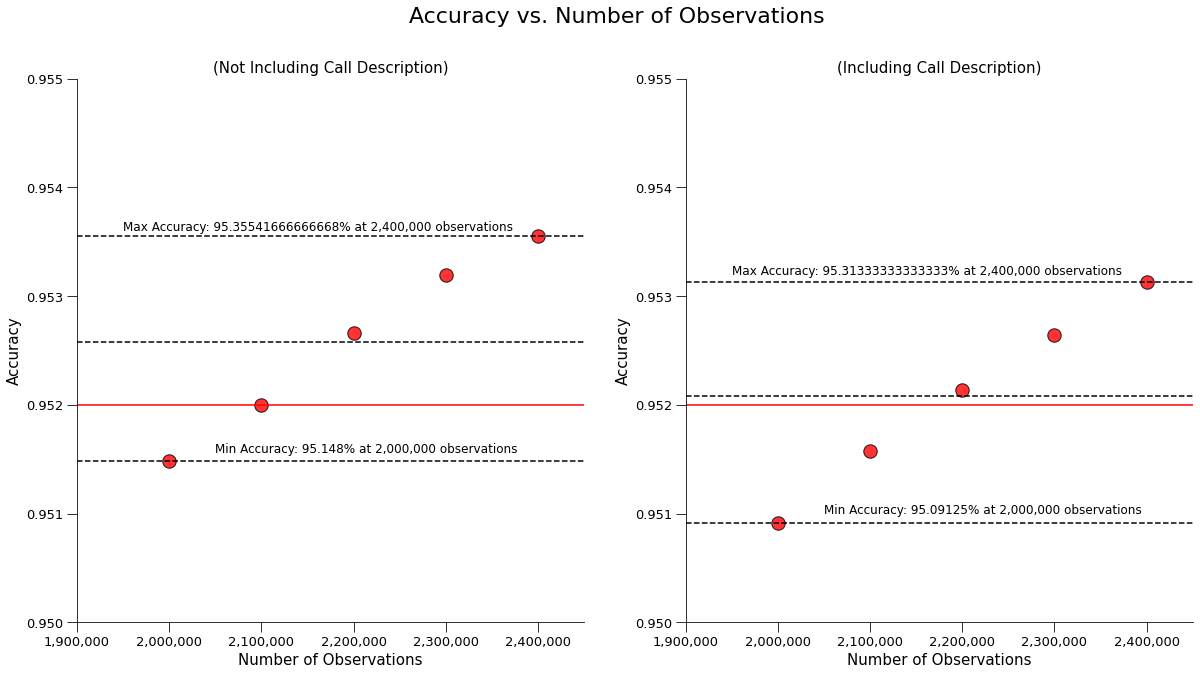

In [86]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig, axs = plt.subplots(1,2, figsize = (20,10))
fig.suptitle("Accuracy vs. Number of Observations", fontsize = 22)
axs[0].set_title("(Not Including Call Description)", fontsize = 15)
axs[1].set_title("(Including Call Description)", fontsize = 15)

sns.scatterplot(data = other_data, x = 'size', y = 'accuracy', s = 180, alpha = .8, edgecolor = 'black', color = 'red', ax = axs[0])
axs[0].axhline(other_data['accuracy'].max(), color = 'black', linestyle = 'dashed')
axs[0].axhline(other_data['accuracy'].min(), color = 'black', linestyle = 'dashed')
axs[0].axhline(other_data['accuracy'].mean(), color = 'black', linestyle = 'dashed')

sns.scatterplot(data = score_frame, x = 'size', y = 'accuracy', s = 180, alpha = .8, edgecolor = 'black', color = 'red', ax = axs[1])
axs[1].axhline(score_frame['accuracy'].max(), color = 'black', linestyle = 'dashed')
axs[1].axhline(score_frame['accuracy'].min(), color = 'black', linestyle = 'dashed')
axs[1].axhline(score_frame['accuracy'].mean(), color = 'black', linestyle = 'dashed')

axs[0].axhline(.952, color = 'red')
axs[1].axhline(.952, color = 'red')

axs[0].set_xlabel('Number of Observations', fontsize = 15)
axs[0].set_ylabel('Accuracy', fontsize = 15)
axs[0].tick_params(size = 10)
axs[0].set_xlim([1900000,2450000])
axs[0].set_ylim([.95,.955])
axs[0].ticklabel_format(style = 'plain')
axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
most_accurate = other_data[(other_data.accuracy == other_data["accuracy"].max())]["size"].values[0]
least_accurate = other_data[(other_data.accuracy == other_data["accuracy"].min())]["size"].values[0]
axs[0].annotate(f'Max Accuracy: {(other_data["accuracy"].max()) * 100}% at {"{:,}".format(most_accurate)} observations', 
            xy= [1950000,.9536], 
            fontsize = 12)
axs[0].annotate(f'Min Accuracy: {(other_data["accuracy"].min()) * 100}% at {"{:,}".format(least_accurate)} observations', 
            xy= [2050000,.95156], 
            fontsize = 12)


axs[1].set_xlabel('Number of Observations', fontsize = 15)
axs[1].set_ylabel('Accuracy', fontsize = 15)
axs[1].tick_params(size = 10)
axs[1].set_xlim([1900000,2450000])
axs[1].set_ylim([.95,.955])
axs[1].ticklabel_format(style = 'plain')
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
most_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].max())]["size"].values[0]
least_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].min())]["size"].values[0]
axs[1].annotate(f'Max Accuracy: {(score_frame["accuracy"].max()) * 100}% at {"{:,}".format(most_accurate)} observations', 
            xy= [1950000,.9532], 
            fontsize = 12)
axs[1].annotate(f'Min Accuracy: {(score_frame["accuracy"].min()) * 100}% at {"{:,}".format(least_accurate)} observations', 
            xy= [2050000,.951], 
            fontsize = 12)

sns.set

sns.despine()
#plt.savefig("XGB_classifier_vs-2")

In [ ]:
detroit_df.shape

bst = clf_xgb.get_booster()

node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb,
                num_trees=0,
                size="10,10"
                condition_node_params=node_parmas,
                leaf_node_params=leaf_params
               )